## Wikipedia Page View Retrieval and Digital Data Comparisons

### Pageview Retrieval

In [1]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
import requests
import bs4
from bs4 import BeautifulSoup
import re

#from requests.structures import CaseInsensitiveDict
#from ratelimit import limits, RateLimitException, sleep_and_retry
# pip install ratelimit

In [2]:
# Read in speciesinfo CSV
species = pd.read_csv("csv/speciesinfo.csv", sep = ";")
species.drop_duplicates(inplace = True)
species = species.reset_index(drop = True)
len(species)

561

## Wikipedia API

In [ ]:
# pip3 install wikipedia-api
import wikipediaapi
# only english language pages
api = wikipediaapi.Wikipedia('en')

wikiurls = []
# loop through the unique species names
for name in species['scientific_name'].unique():
    # Spaces to be replaced with underscore for Wiki's API
    name = name.replace(" ", "_")
    # retrieve each species' page, will redirect when called with scientifc name
    p = api.page(name)
    try:
        # Fullurl will contain the title of the species' wiki article
        data = {'url': p.fullurl, 'scientific_name': name}
        wikiurls.append(data)
    # species did not return with a valid url, no page exists for the species
    except KeyError:
        pass
    
# investigate how many species left   
len(wikiurls)

In [31]:
def WikiPageView(title):
    """
    Function to call Wikipedia's Pageview API
    
    Parameters: string
    
    """
    
    # Calling monthly page views of each species from 2015-2020
    address = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/" + title + "/monthly/2015010100/2020123100"

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    # Personal username for identification for the Wikipedia API
    headers = {'User-Agent': 'reddalisa/3.10.6 (alisa.redding@helsinki.fi)'}
    
    resp = requests.get(address, headers=headers)
    details = resp.json()
    
    return details 
      
    
# Create an empty list to store the pageviews results into
newframe = []  

# loop over the urls to extract the titles of the wikipages
for n in range(len(wikiurls)):
    name = wikiurls[n]['url'].removeprefix("https://en.wikipedia.org/wiki/")
    # using the extracted name, run through the function
    result = WikiPageView(name)
    sci_name = wikiurls[n]['scientific_name']
    
    try:
        # loop over the json results to store the relevant information 
        for n in range(len(result['items'])):
            title = result['items'][n]['article']
            date = result['items'][n]['timestamp']
            # Remove 00 at end of date string that is marking the hour
            date = date[:-2]
            view = result['items'][n]['views']
            
            # create a dictionary object 
            data = {'title': title, 'date': date, 'views': view, 'scientific_name' : sci_name}
            newframe.append(data)
    # Some pages have not been incorporated into the PageViews API yet, they will be passed
    except KeyError:
        pass



In [37]:
# Create a dataframe from the list
#wikipage = pd.DataFrame(newframe)
#wikipage["datetime"] = wikipage["date"].apply(pd.to_datetime)
wikipage = wikipage.drop(columns = 'date')
wikipage['title'] = wikipage["title"].apply(lambda x: x.replace("_", " "))
wikipage['scientific_name'] = wikipage["scientific_name"].apply(lambda x: x.replace("_", " "))
#len(wikipage['name'].unique())

In [48]:
# view highest view count
wikipage.sort_values(by="views", ascending = False)

,title,views,scientific_name,datetime
2762,Tiger,694465,Panthera tigris,2020-03-01
9262,Red panda,652891,Ailurus fulgens,2017-05-01
614,Lion,574872,Panthera leo,2017-03-01
650,Lion,574083,Panthera leo,2020-03-01
2763,Tiger,540666,Panthera tigris,2020-04-01
...,...,...,...,...
34056,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-07-01
34057,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-08-01
34058,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-09-01
34059,Milne-Edwards's sifaka,0,Propithecus edwardsi,2018-10-01


In [46]:
speciesinfo = pd.merge(species, wikipage.groupby('scientific_name')['views'].sum().reset_index(), on='scientific_name', how = 'inner').drop_duplicates()

In [47]:
speciesinfo.to_csv("csv/fullspeciesinfo.csv", sep = ";", index = False)

In [52]:
wikipage.to_csv("csv/wikipageviews.csv", sep = ";", index = False)

In [2]:
wikianalysis = pd.read_csv("csv/wikipageviews.csv", sep = ";")

In [5]:
wikianalysis['scientific_name'].nunique()

548

## Temporal Visualization & WordCloud

### Articles: Facebook shares

In [8]:
# Read in the updated CSVs 

#articles = pd.read_csv("updated_articles_w_engangement.csv", sep = ";")
articles2 = pd.read_csv("alltext-no-engagement-sentimet.csv", sep = ";")
#undoc = pd.read_csv("csv/undoc_species_articles.csv", sep = ";")
speciesinfo = pd.read_csv("csv/fullspeciesinfo.csv", sep = ";")
wiki = pd.read_csv("csv/wikipageviews.csv", sep = ";")

In [15]:
biodiversity = articles2[articles2['text'].str.contains("biodiversity")].reset_index(drop=True)

In [3]:
speciesinfo = pd.merge(speciesinfo, wiki[['scientific_name', 'title']], on='scientific_name', how='right').drop_duplicates().reset_index(drop=True)

In [4]:
# Simplify the IUCN categories
articles["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC", "Lower Risk/conservation dependent": "LC",
                                "Vulnerable" : "VU", "Near Threatened" : "NT", "Critically Endangered" : "CR",
                          "Extinct in the Wild" : "EW", "Endangered" : "EN", "Data Deficient" : "DD", 
                          "Extinct" : "EX"}, inplace=True)

In [5]:
articles = pd.merge(articles, speciesinfo, on = "scientific_name", how = "left")

In [6]:
# Only keep articles with shares
shared = articles.loc[articles['shares'] > 0].reset_index(drop = True)

# Define a binary classification in a new column for popularity
shared['Popular'] = 0

# Loop over the values in the shares column and if above the median classify as popular
for x in shared["shares"]:
    if x > shared["shares"].mean():
        shared.loc[shared['shares'] == x, 'Popular'] = 1

In [35]:
from PIL import Image 

pangolin_mask = np.array(Image.open("figures/pangolin_silhouette.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
# Transform your mask into a new one that will work with the function:
transformed_mask = np.ndarray((pangolin_mask.shape[0],pangolin_mask.shape[1]), np.int32)

for i in range(len(pangolin_mask)):
    transformed_mask[i] = list(map(transform_format, pangolin_mask[i]))

In [ ]:
from wordcloud import WordCloud #pip install wordcloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Articles with greater than the avergae amount of shares in the dataset
popular = shared.loc[shared['Popular'] == 1]
# Articles with greater than 10,000 shares on Facebook (23 articles)
above10thou = articles.loc[articles['shares'] > 10000].reset_index(drop = True)

# Change to choose a certain IUCN status to display
critical = articles.loc[articles['iucn_status'] == "CR"].reset_index(drop = True)
# PLant kingdom articles
plants = articles.loc[articles['Kingdom'] == "Plantae"].reset_index(drop = True)
# Animal kingdom articles
animals = articles.loc[articles['Kingdom'] == "Animalia"].reset_index(drop = True)
# Bird articles
birds = articles.loc[articles['Class'] == "Aves"].reset_index(drop = True)
# Mammal articles
mammals = articles.loc[articles['Class'] == "Mammalia"].reset_index(drop = True)
# Reptile articles
reptiles = articles.loc[articles['Class'] == "Reptilia"].reset_index(drop = True)
amphibia = articles.loc[articles['Class'] == "Amphibia"].reset_index(drop = True)
insects = articles.loc[articles['Class'] == "Insecta"].reset_index(drop = True)
pangolins = articles.loc[articles['Order'] == "Pholidota"].reset_index(drop = True)
# UNDOC's species to watch for illegal trade
undoc = undoc.dropna(subset = ['title'])


In [23]:
len(biodiversity)

1716

There are 109385 words in the combination of all cells in column title.


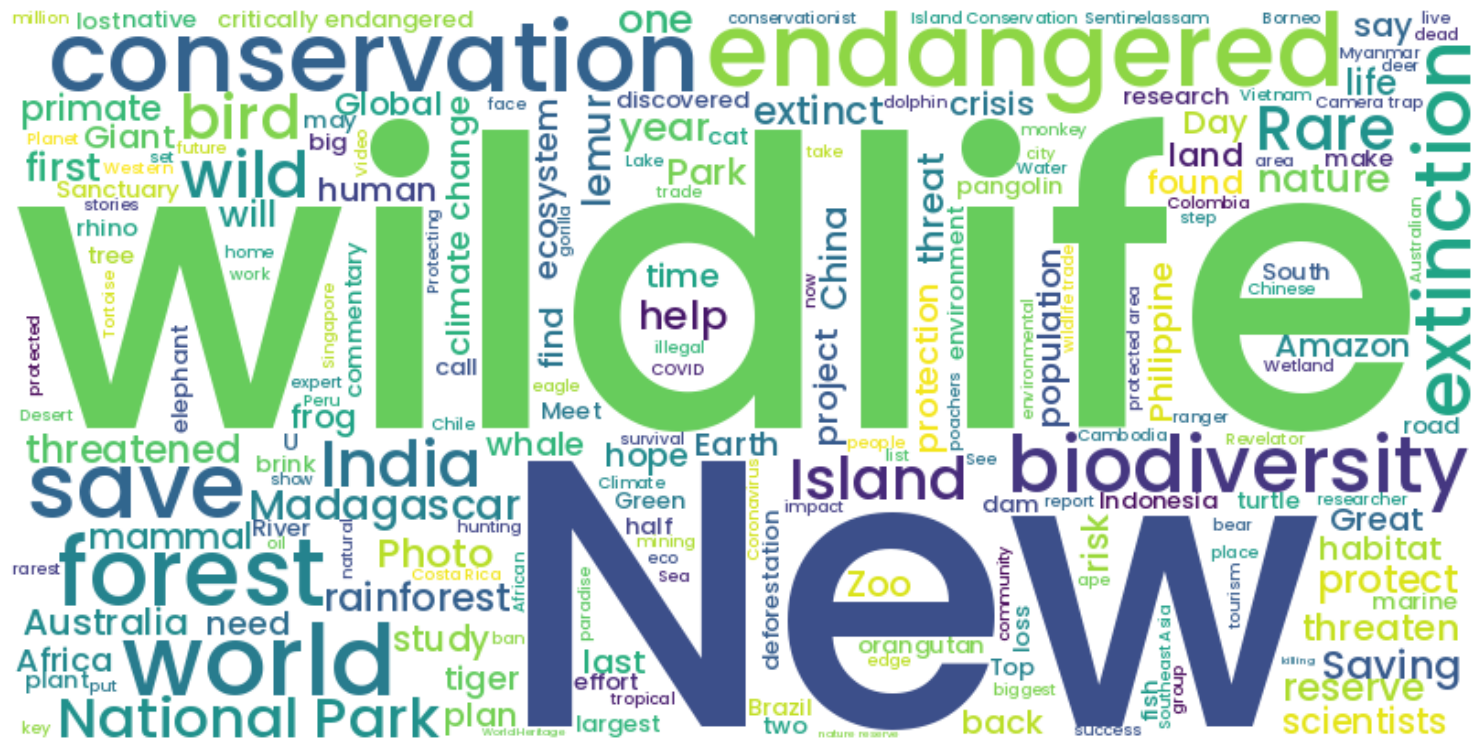

In [22]:
# Change to title or text
text = " ".join(i for i in biodiversity.title)
print ("There are {} words in the combination of all cells in column title.".format(len(text))) 

stopwords = set(STOPWORDS)
stopwords.update(["Animal", "animal", "Animals", "species", "s"])
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      font_path='fonts/Poppins-Medium.ttf',
                      width=800, 
                      height=400, 
                      #mask=transformed_mask, 
                      #contour_width=1, 
                      #contour_color='green'
                      ).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

#wordcloud.to_file("figures/wordcloud_biodiversity.png")

In [ ]:
articles = articles.drop(columns = ["date_saved", "sharecount_x", "sharecount_y"])
articles['date'] = pd.to_datetime(articles['date'])

In [125]:
articleshares = articles.groupby([(articles.date.dt.year), (articles.date.dt.month), (articles.scientific_name)])['shares'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

ar16 = articleshares.loc[articleshares['Year'].isin([2016])]
chosen = ar16.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar16 = ar16.loc[ar16['scientific_name'].isin(chosen)]

ar17 = articleshares.loc[articleshares['Year'].isin([2017])]
chosen = ar17.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar17 = ar17.loc[ar17['scientific_name'].isin(chosen)]

ar18 = articleshares.loc[articleshares['Year'].isin([2018])]
chosen = ar18.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar18 = ar18.loc[ar18['scientific_name'].isin(chosen)]

ar19 = articleshares.loc[articleshares['Year'].isin([2019])]
chosen = ar19.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar19 = ar19.loc[ar19['scientific_name'].isin(chosen)]

ar20 = articleshares.loc[articleshares['Year'].isin([2020])]
chosen = ar20.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar20 = ar20.loc[ar20['scientific_name'].isin(chosen)]

In [7]:
# Replace common name for Crocodylus cataphractus which should be West African slender-snouted crocodile 
# and not the Genus name Mecistops. New scientific name should be updated to Mecistops cataphractus

articles['title_y'] = articles['title_y'].replace('Mecistops', 'West African slender-snouted crocodile')
speciesinfo['title'] = speciesinfo['title'].replace('Mecistops', 'West African slender-snouted crocodile')

In [8]:
#Isolating top 20 most shared species' articles 

shared = articles.groupby('scientific_name')['shares'].sum().nlargest(20).reset_index()#['scientific_name'].values.tolist()
#articspan = articles.loc[articles['scientific_name'].isin(shared)]
#articspan = articles.loc[articles.date.dt.year > 2015]
#articspan = articspan.reset_index(drop = True)

#shared = shared.drop(columns = ["sharecount"])
shared = pd.merge(shared, speciesinfo, on = "scientific_name", how = "left")
#shared = shared.drop(columns = ["sharecount"])

In [9]:
# Isolate 15 most shared titles from Facebook
# Drop irrelevant title (identified from a manual inspection) 

titles = articles.groupby(['scientific_name', 'title_y', 'title_x', 'Class_x'])['shares'].sum().nlargest(16).reset_index()
titles = titles.drop(5).reset_index(drop=True)

In [27]:
titles

,scientific_name,title_y,title_x,Class_x,shares
0,Physeter macrocephalus,Sperm whale,"Found, Inside Dead Sperm Whale: 100 Plastic Cu...",Mammalia,259996.0
1,Pongo pygmaeus,Bornean orangutan,Pregnant orang-utan pictured clinging to final...,Mammalia,122918.0
2,Leopardus pardalis,Ocelot,Rare Footage of Arizona Ocelot Shows What Coul...,Mammalia,58998.0
3,Struthio camelus,Common ostrich,Quiz: What animal does each eye belong to?,Aves,51545.0
4,Crocodylus cataphractus,West African slender-snouted crocodile,"Fate of Africa's newest, rarest crocodile tied...",Reptilia,47212.0
5,Manis tricuspis,Tree pangolin,"Is This Clothing, Food, or an Endangered Speci...",Mammalia,46432.0
6,Chelonoidis niger,Galápagos tortoise,A Giant Galapagos Tortoise Once Thought Extinc...,Reptilia,32920.0
7,Leopardus pardalis,Ocelot,Texas Ocelot Den Found for First Time in Two D...,Mammalia,30420.0
8,Semnopithecus entellus,Northern plains gray langur,This Roadside Mechanic from Rajasthan Has Resc...,Mammalia,28814.0
9,Pelecanus crispus,Dalmatian pelican,Amazing Winners of the 2019 Bird Photographer ...,Aves,24795.0


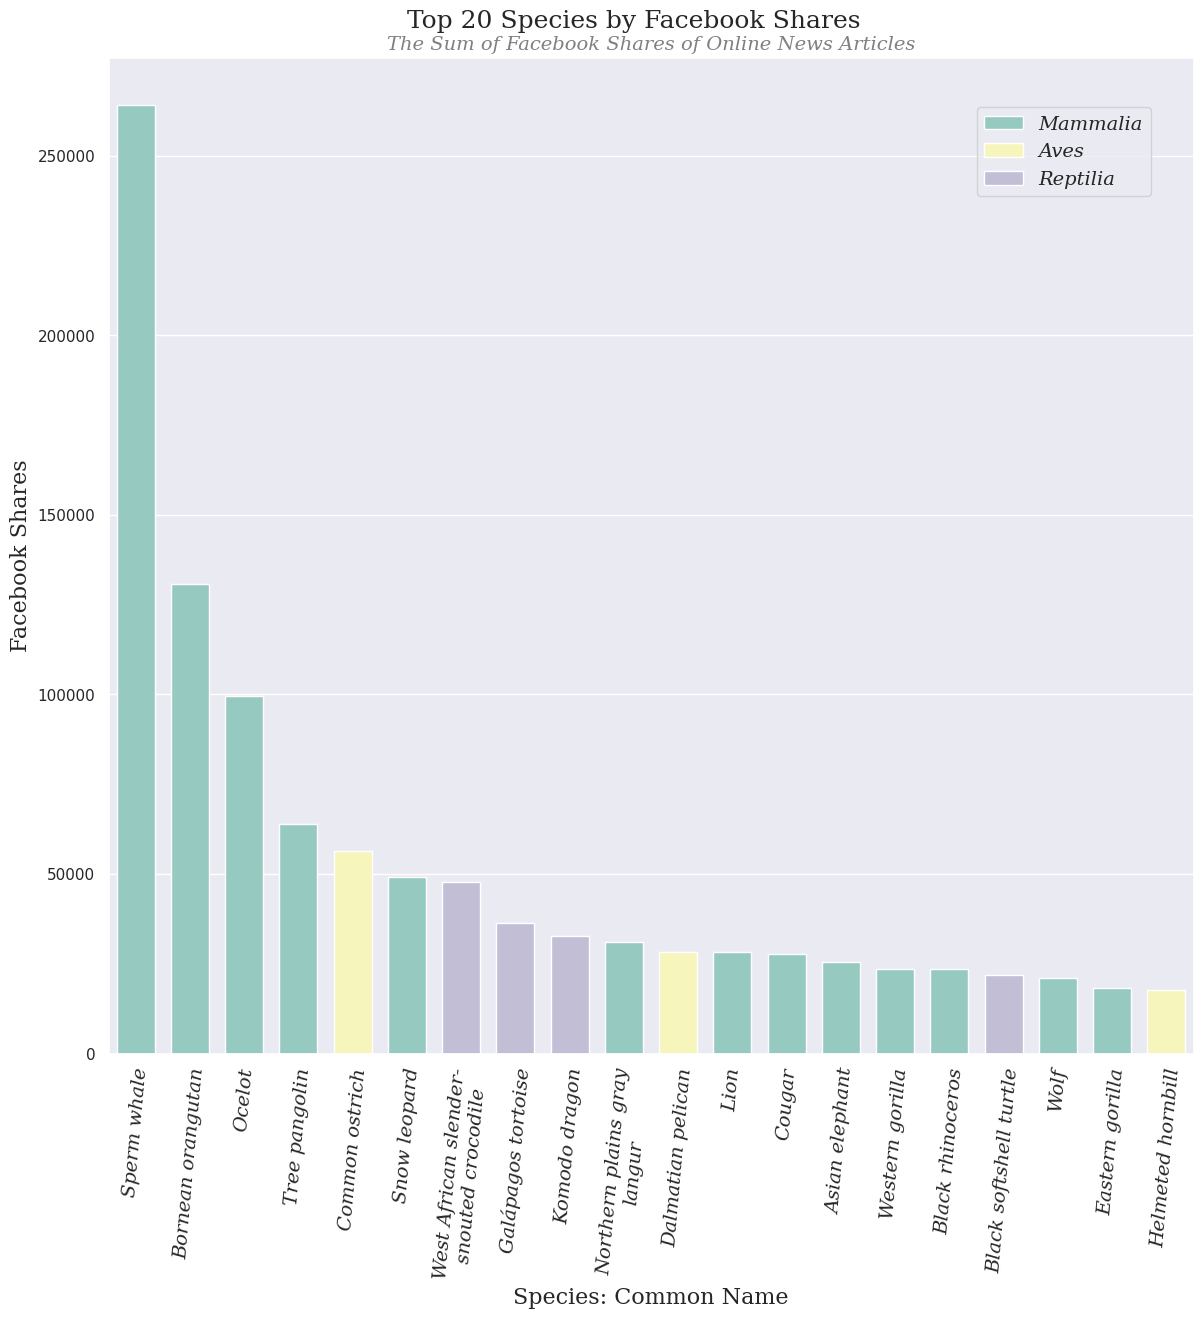

In [11]:
# Visualization of species with highest share count overall

import seaborn as sns
from matplotlib import rc, font_manager, ticker
from textwrap import wrap


sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})

palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}
plt.rcParams["axes.grid.axis"] ="y"

ax = sns.barplot(
    x = 'title',
    y = 'shares',
    hue = 'Class',
    data = shared, 
    width = 0.7, palette = palette, dodge = False
)
ax.set_xlabel('Species: Common Name', fontsize=16, family = "Serif")
ax.set_ylabel('Facebook Shares', fontsize=16, family = "Serif")


# Add suptitle above the title
plt.suptitle("Top 20 Species by Facebook Shares\n", fontsize=18, family= 'Serif')
plt.subplots_adjust(top=0.94)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('The Sum of Facebook Shares of Online News Articles', fontsize = 14, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                  weight='regular',
                                  style='italic', size=14)

#fontProperties = {'family': 'Serif', 'color':  'k', 'weight': 'normal', 'style':'italic', 'size': 12}
 
# Set font for x-axis labels
for label in ax.get_xticklabels():
    label.set_fontproperties(font)

import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=85)
  

wrap_labels(ax, 25)   
#ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 14, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/top_20_species_fb.png', bbox_inches = 'tight')

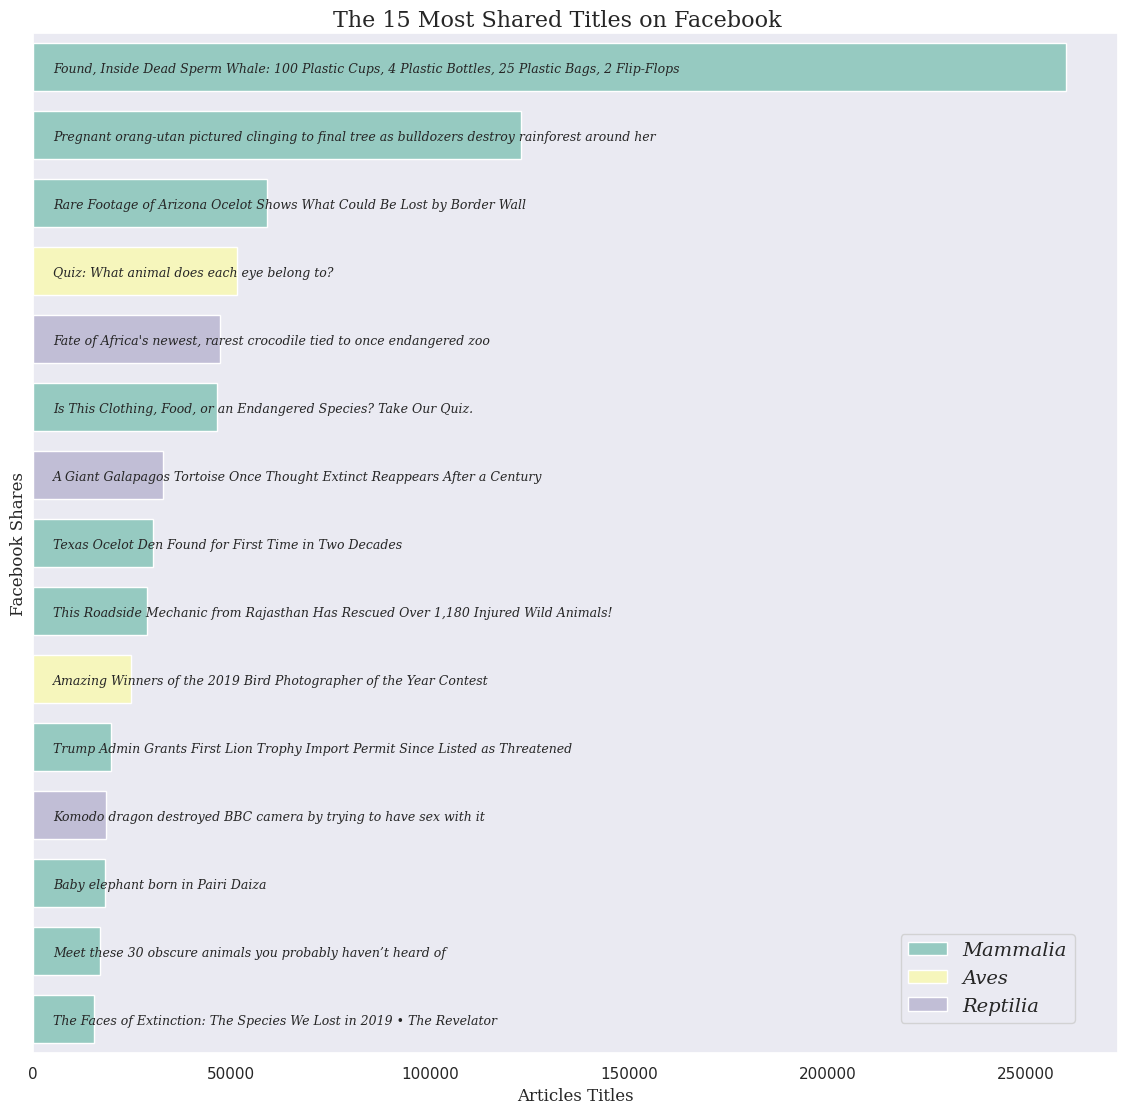

In [68]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})
plt.rcParams["axes.grid.axis"] ="y"

plt.rcParams["axes.axisbelow"] = "line"


palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}
label_dict = {"Mammalia": "Mammalia", "Reptilia":"Reptilia", "Aves":"Aves"}

# Define fontstyle for legend
label_font = {'family': 'serif',
              'size': 12,
              'weight': 'italic'}


ax = sns.barplot(
    x = 'shares', 
    y = 'title_x',
    hue = 'Class_x',
    data = titles,
    width = 0.7,
    #marker = "o", 
    palette = "Set3",
    dodge = False)


ax.set_ylabel('Facebook Shares', fontsize=12, family = "Serif")
ax.set_xlabel('Articles Titles', fontsize=12, family = "Serif")
#ax.set_yscale('log')

# Add suptitle above the title
plt.suptitle("The 15 Most Shared Titles on Facebook\n", fontsize=16, family = 'Serif')
plt.subplots_adjust(top=0.96)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
#ax.set_title('The Sum of Facebook Shares of Online News Articles', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                  weight='regular',
                                  style='italic', size=14)

font_titles = {'family': 'Serif','weight': 'normal','style':'italic','size': 9}

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_yticklabels(titles['title_x'], horizontalalignment = "left", fontdict = font_titles)
ax.tick_params(axis='y', direction = "in", pad = -15)
#ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 12, left = True)
#plt.rcParams["axes.grid.axis"] ="x"

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(0.8, 0.03), loc='lower left', borderaxespad=0, prop=font)
#ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/facebook_sharedarticles.png', bbox_inches = 'tight')

### Wikipedia Pageviews

In [3]:
# read in store wiki data
wiki = pd.read_csv("csv/wikipageviews.csv", sep = ";")
# merge with relevant species info
wiki = pd.merge(wiki, species[['scientific_name', 'Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species']], on = "scientific_name", how='left')
# transform date column into datetime for processing + plotting purposes 
wiki["datetime"] = pd.to_datetime(wiki['datetime'])

# create a grouped by month+year dataframe 
temporal_wiki = wiki.groupby([(wiki.datetime.dt.year), (wiki.datetime.dt.month), (wiki.scientific_name)])['views'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

In [7]:
# Finding 5 most popular species of each year and plot their popularity over the year
yr20 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])]
chosen20 = yr20.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen20 = chosen20['scientific_name'].values.tolist()
yr20 = yr20.loc[yr20['scientific_name'].isin(chosen20)]

yr19 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])]
chosen19 = yr19.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen19 = chosen19['scientific_name'].values.tolist()
yr19 = yr19.loc[yr19['scientific_name'].isin(chosen19)]

yr18 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])]
chosen18 = yr18.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen18 = chosen18['scientific_name'].values.tolist()
yr18 = yr18.loc[yr18['scientific_name'].isin(chosen18)]

yr17 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])]
chosen17 = yr17.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen17 = chosen17['scientific_name'].values.tolist()
yr17 = yr17.loc[yr17['scientific_name'].isin(chosen17)]

yr16 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])]
chosen16 = yr16.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen16 = chosen16['scientific_name'].values.tolist()
yr16 = yr16.loc[yr16['scientific_name'].isin(chosen16)]

# A list of unique species composed of each years' top 5 species 
#uniques = list(set(chosen20 + chosen19 + chosen18 + chosen17 + chosen16))

In [10]:
# A list of 10 species with the highest pageview count for one month from the entire 5 year timespan that has been collected (the highest peaks)
peaks = wiki.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
# A list of 10 species with the highest overall pageview count from the entire 5 year timespan 
topoverall = wiki.groupby('scientific_name')['views'].sum().nlargest(10).reset_index()['scientific_name'].values.tolist()
# Change to topoverall or peaks to store an excerpt of the dataframe to visualize
topalltime = wiki.loc[wiki['scientific_name'].isin(topoverall)]
alltimepeaks = wiki.loc[wiki['scientific_name'].isin(peaks)]


# Species specific investigations
# Visualizations for articles tagged with Aves 
birds = wiki.loc[wiki['Class'] == "Aves"].reset_index(drop = True)
# A list of 10 birds with highest peaks
birdpeaks = birds.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimebirds = birds.loc[birds['scientific_name'].isin(birdpeaks)]

# Visualizations for articles tagged with Mammalia
mammals = wiki.loc[wiki['Class'] == "Mammalia"].reset_index(drop = True)
# A list of 10 birds with highest peaks
mammalpeaks = mammals.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimemammals = mammals.loc[mammals['scientific_name'].isin(mammalpeaks)]

# Visualizations for articles tagged with Reptilia
reps = wiki.loc[wiki['Class'] == "Reptilia"].reset_index(drop = True)
# A list of 10 birds with highest peaks
reppeaks = reps.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
alltimereps = reps.loc[reps['scientific_name'].isin(reppeaks)]

In [9]:
# Store to CSV
topalltime.to_csv("csv/wiki-top10alltime.csv", sep = ";", index = False)
alltimepeaks.to_csv("csv/wiki-10alltimepeaks.csv", sep = ";", index = False)

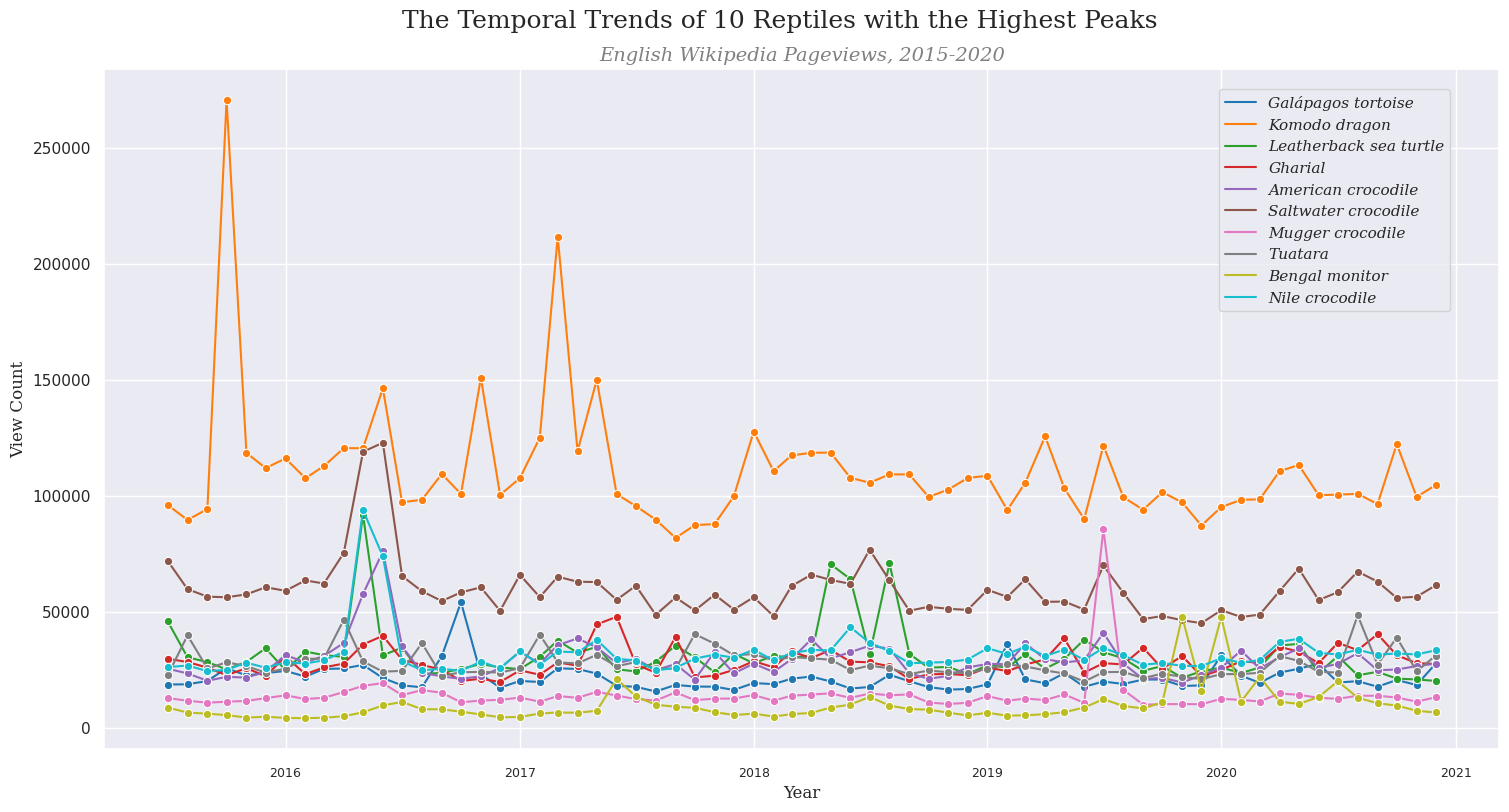

In [111]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
# Import packages
import cmasher as cmr

# Take 5 colors from rainforest in [0.15, 0.85] range in HEX
colors = cmr.take_cmap_colors('tab10', 
                              10, 
                              cmap_range=(0.02, .98), 
                              return_fmt='hex')

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(18,8.5)})
ax = sns.lineplot(
    x = 'datetime',
    y = 'views',
    hue = 'title',
    data = alltimereps, # Change to topalltime or alltimepeaks
    marker = "o", 
    palette = colors
)

ax.set_xlabel('Year', fontsize=12, family = "Serif")
ax.set_ylabel('View Count', fontsize=12, family = "Serif")
#plt.figure(figsize=(15,6))

# Add suptitle above the title
plt.suptitle("The Temporal Trends of 10 Reptiles with the Highest Peaks\n", fontsize=18, family = 'Serif')
plt.subplots_adjust(top=0.91)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('English Wikipedia Pageviews, 2015-2020', fontsize = 14, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=11)

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 9, left = True)
ax.legend(bbox_to_anchor=(.965, 0.97), loc='upper right', borderaxespad=0, prop=font)
plt.savefig('figures/wiki10peaksreptiles.png', bbox_inches = 'tight')

In [44]:
year2020 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])].drop_duplicates("Month").sort_values("Month")
year2019 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])].drop_duplicates("Month").sort_values("Month")
year2018 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])].drop_duplicates("Month").sort_values("Month")
year2017 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])].drop_duplicates("Month").sort_values("Month")
year2016 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])].drop_duplicates("Month").sort_values("Month")

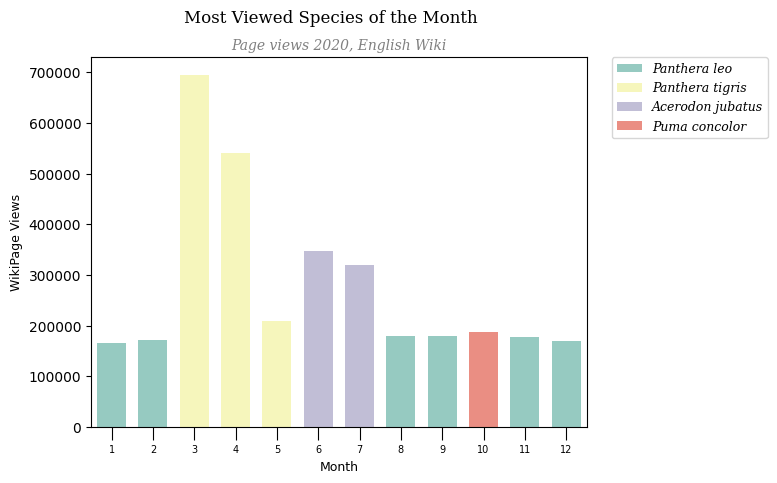

In [41]:
import seaborn as sns
import matplotlib.font_manager as font_manager

ax = sns.barplot(
    x = 'Month',
    y = 'views',
    hue = 'scientific_name',
    data = year2020, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Month', fontsize=9)
ax.set_ylabel('WikiPage Views', fontsize=9)


# Add suptitle above the title
plt.suptitle("Most Viewed Species of the Month\n", fontsize=12, family = 'Serif')

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2020, English Wiki', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=9)

ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
#plt.savefig('figures/2020_wikipageviews.png', bbox_inches = 'tight')

In [19]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Top 20 species in Wikipedia dataset
top20 = wiki.groupby(['title', 'scientific_name'])['views'].sum().nlargest(20).reset_index()

# Merge with the CITES infoset
top20= top20.merge(cites1, on = 'scientific_name', how = 'left').drop_duplicates().reset_index(drop=True)

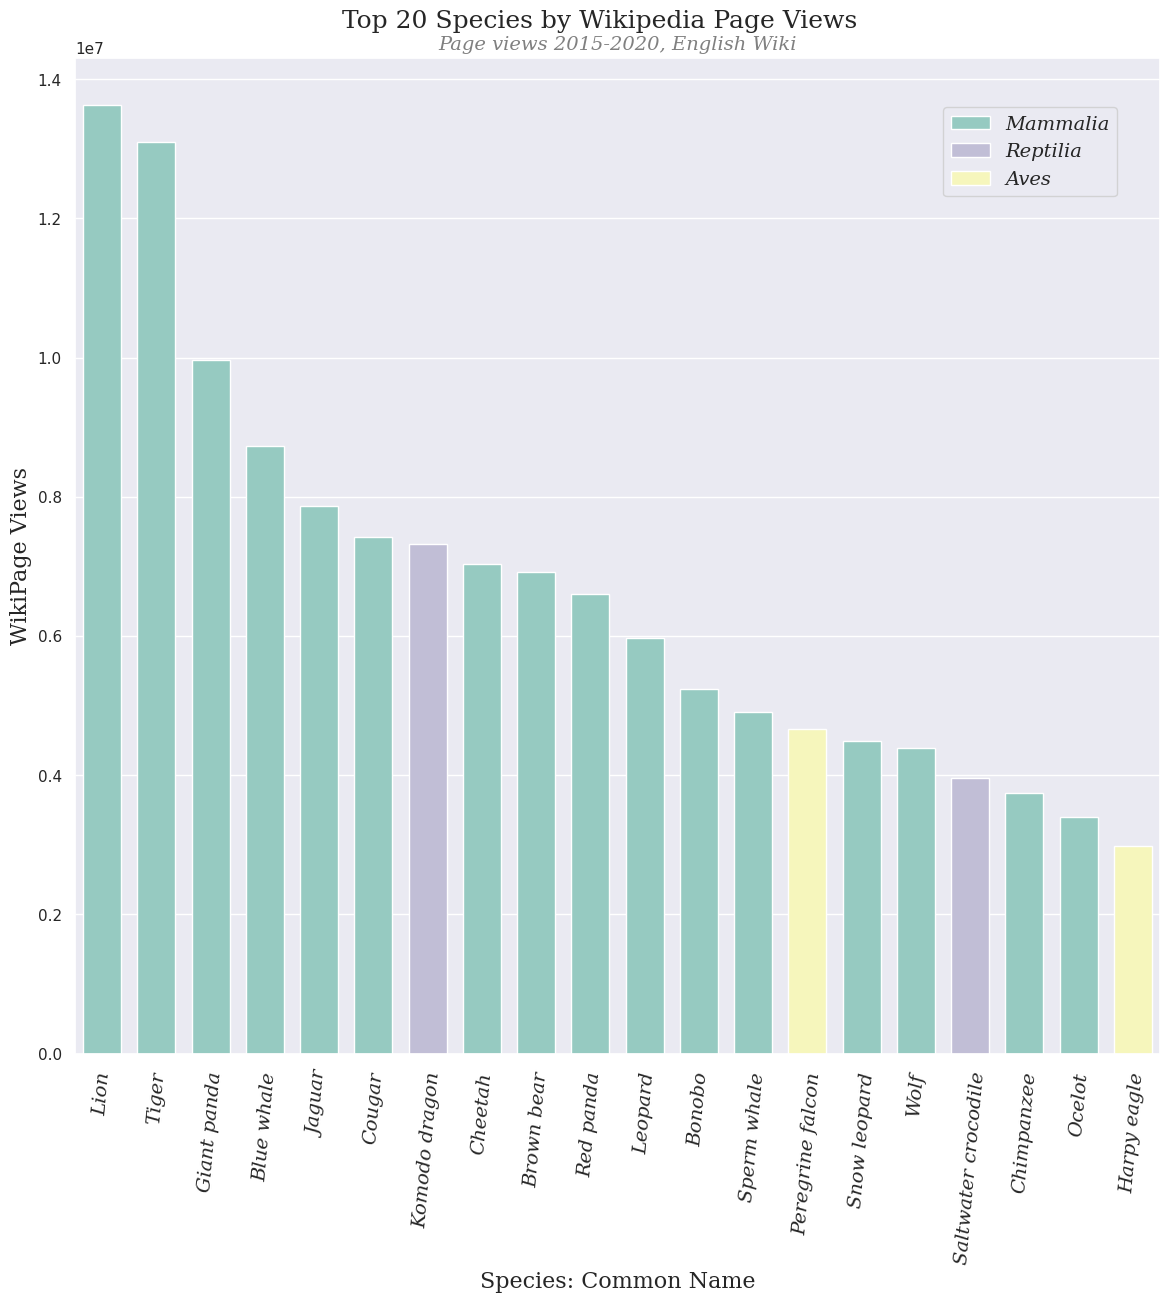

In [21]:
import seaborn as sns
palette = {"Mammalia": "#8dd3c7", "Reptilia": "#bebada", "Aves": "#ffffb3"}

ax = sns.barplot(
    x = 'title',
    y = 'views',
    hue = 'Class',
    data = top20, 
    width = 0.7, palette = palette, dodge = False
)
ax.set_xlabel('Species: Common Name', fontsize=16, family = "Serif")
ax.set_ylabel('WikiPage Views', fontsize=16, family = "Serif")


# Add suptitle above the title
plt.suptitle("Top 20 Species by Wikipedia Page Views\n", fontsize=18, family= 'Serif')
plt.subplots_adjust(top=0.94)

# Add title
ax.set_title('Page views 2015-2020, English Wiki', fontsize = 14, color="grey", style='italic', family = 'Serif')



font = font_manager.FontProperties(family='Serif',
                                  weight='regular',
                                  style='italic', size=14)

#fontProperties = {'family': 'Serif', 'color':  'k', 'weight': 'normal', 'style':'italic', 'size': 12}
    
for label in ax.get_xticklabels():
    label.set_fontproperties(font)


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 14, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/top_20_species_wiki.png', bbox_inches = 'tight')

### Investigation of article content by year-month and species

In [7]:
# Read in the processed dataframe
alltext = pd.read_csv("alltext-no-engagement-sentimet.csv", sep = ";")
len(alltext)

13066

In [9]:
alltext["date"] = pd.to_datetime(alltext['date'])

In [32]:
## alltimepeaks stored with 10 species with highest peaks in wikipageviews over a 5 year timespan
# we will fetch the dates with the most notable peaks and look for article content in the same time
# since it is difficult to know what causes a peak and its connection to the media we will investigate 
# the article content of one month prior and one month after in addition to the month in question 

speciespeaks = alltimepeaks.groupby('scientific_name')['views'].nlargest(1).reset_index().drop(columns = "level_1")

In [50]:
excerpt = alltimepeaks.loc[alltimepeaks['views'].isin(speciespeaks['views'])].reset_index(drop = True)

In [ ]:
# Assuming df1 and df2 are your dataframes

# Extract the year and month from the 'datetime' column in df1
alltext['year'] = pd.to_datetime(alltext['date']).dt.year
alltext['month'] = pd.to_datetime(alltext['date']).dt.month

# Extract the year and month from the 'date' column in df2
excerpt['year'] = pd.to_datetime(excerpt['datetime']).dt.year
excerpt['month'] = pd.to_datetime(excerpt['datetime']).dt.month

In [68]:
df1 = excerpt.copy()

In [69]:
# Create an empty dataframe to store the new rows
new_rows = pd.DataFrame(columns=df1.columns)

# Iterate over each species in df1
for index, row in df1.iterrows():
    species_month = row['month']
    species_year = row['year']
    
    # Calculate the adjacent months
    prev_month = species_month - 1
    next_month = species_month + 1
    
    # Create two new rows with adjusted months
    prev_row = row.copy()
    prev_row['month'] = prev_month
    prev_row['datetime'] = pd.to_datetime(f"{species_year}-{prev_month}-01")
    
    next_row = row.copy()
    next_row['month'] = next_month
    next_row['datetime'] = pd.to_datetime(f"{species_year}-{next_month}-01")
    
    # Append the new rows to the dataframe
    new_rows = new_rows.append(prev_row)
    new_rows = new_rows.append(next_row)

# Concatenate the original dataframe with the new rows
df1 = pd.concat([df1, new_rows], ignore_index=True)

# Sort the dataframe by scientific_name and datetime
df1 = df1.sort_values(['scientific_name', 'datetime'])

# Reset the index
df1 = df1.reset_index(drop=True)

# Print the updated dataframe
df1

/tmp/ipykernel_44/2456268825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(prev_row)
/tmp/ipykernel_44/2456268825.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(next_row)
/tmp/ipykernel_44/2456268825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(prev_row)
/tmp/ipykernel_44/2456268825.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(next_row)
/tmp/ipykernel_44/2456268825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

,title,views,scientific_name,datetime,Kingdom,Class,Order,Family,Genus,Species,year,month
0,Giant golden-crowned flying fox,347925,Acerodon jubatus,2020-05-01,Animalia,Mammalia,Chiroptera,Pteropodidae,Acerodon,jubatus,2020,5
1,Giant golden-crowned flying fox,347925,Acerodon jubatus,2020-06-01,Animalia,Mammalia,Chiroptera,Pteropodidae,Acerodon,jubatus,2020,6
2,Giant golden-crowned flying fox,347925,Acerodon jubatus,2020-07-01,Animalia,Mammalia,Chiroptera,Pteropodidae,Acerodon,jubatus,2020,7
3,Giant panda,411539,Ailuropoda melanoleuca,2020-02-01,Animalia,Mammalia,Carnivora,Ursidae,Ailuropoda,melanoleuca,2020,2
4,Giant panda,411539,Ailuropoda melanoleuca,2020-03-01,Animalia,Mammalia,Carnivora,Ursidae,Ailuropoda,melanoleuca,2020,3
5,Giant panda,411539,Ailuropoda melanoleuca,2020-04-01,Animalia,Mammalia,Carnivora,Ursidae,Ailuropoda,melanoleuca,2020,4
6,Red panda,652891,Ailurus fulgens,2017-04-01,Animalia,Mammalia,Carnivora,Ailuridae,Ailurus,fulgens,2017,4
7,Red panda,652891,Ailurus fulgens,2017-05-01,Animalia,Mammalia,Carnivora,Ailuridae,Ailurus,fulgens,2017,5
8,Red panda,652891,Ailurus fulgens,2017-06-01,Animalia,Mammalia,Carnivora,Ailuridae,Ailurus,fulgens,2017,6
9,Blue whale,328964,Balaenoptera musculus,2019-04-01,Animalia,Mammalia,Cetacea,Balaenopteridae,Balaenoptera,musculus,2019,4


In [70]:
# Merge df1 and df2 based on scientific_name, year, and month
merged_df = pd.merge(alltext, df1[['scientific_name', 'year', 'month', 'views']], on=['scientific_name'])

In [71]:
# Filter the merged dataframe to include only the specific month and year
filtered_df = merged_df[(merged_df['month_x'] == merged_df['month_y']) & (merged_df['year_x'] == merged_df['year_y'])]

filtered_df

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class,Order,Family,Genus,...,link,image,date,ner,sentiment,year_x,month_x,year_y,month_y,views
39,Lesser Panda,Ailurus fulgens,"Bhutan, China, India, Lao People's Democratic ...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Ailuridae,Ailurus,...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://america.cgtn.com/wp-content/uploads/20...,2017-04-29,[{'sent': 'Click to share on Weibo (Opens in n...,Positive,2017,4,2017,4,652891
43,Lesser Panda,Ailurus fulgens,"Bhutan, China, India, Lao People's Democratic ...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Ailuridae,Ailurus,...,https://news.google.com/articles/CBMiOWh0dHBzO...,NaN,2017-05-24,"[{'sent': 'Yogesh Rana Magar\n\n', 'ents': {'P...",Negative,2017,5,2017,5,652891
460,Asiatic Lion,Panthera leo,"Afghanistan, Algeria, Angola, Benin, Botswana,...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CBMiemh0dHBzO...,https://images.livemint.com/rf/Image-621x414/L...,2017-03-17,[{'sent': 'New Delhi: The lion population in a...,Positive,2017,3,2017,3,574872
464,Indian Lion,Panthera leo,"Afghanistan, Algeria, Angola, Benin, Botswana,...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CBMiaGh0dHBzO...,https://i.dailymail.co.uk/i/pix/2017/04/27/02/...,2017-04-27,[{'sent': 'One lion did not appreciate being t...,Negative,2017,4,2017,4,574872
957,Siberian Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CBMiX2h0dHBzO...,https://www.worldatlas.com/r/w1200-h701-c1200x...,2020-02-06,[{'sent': 'WorldAtlas.com (the “Website”) is o...,Positive,2020,2,2020,2,694465
960,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CAIiEEx-Q_9pf...,https://imgs.mongabay.com/wp-content/uploads/s...,2020-02-13,"[{'sent': 'For the first time ever, scientists...",Negative,2020,2,2020,2,694465
963,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CAIiEE6FA5bMk...,https://i2-prod.somersetlive.co.uk/incoming/ar...,2020-02-23,[{'sent': 'Sign up to FREE email alerts from S...,Positive,2020,2,2020,2,694465
966,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CBMifmh0dHBzO...,https://cdn.images.express.co.uk/img/dynamic/7...,2020-02-26,[{'sent': 'FREE now and never miss the top Roy...,Negative,2020,2,2020,2,694465
970,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://s.yimg.com/uu/api/res/1.2/aGw3q_cvkTbM...,2020-03-11,[{'sent': 'Denver Zoo’s resident Amur tiger Ni...,Positive,2020,3,2020,3,694465
974,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,https://news.google.com/articles/CAIiEHqzFVAUF...,https://www.nationalgeographic.com/content/dam...,2020-04-01,[{'sent': 'Netflix’s recent documentary minise...,Positive,2020,4,2020,4,694465


In [75]:
filtered_df = filtered_df.sort_values(by="date").reset_index(drop=True)

In [76]:
filtered_df.to_csv("wikipagepeaks-articles.csv", sep = ";", index = False)

### Google Hits 

In [22]:
#google = pd.read_csv("csv/google_hits_species.csv", sep = ";")
#google = google.drop_duplicates().reset_index(drop = True)
top20google = speciesinfo.nlargest(columns = "hits_renew", n = 20)

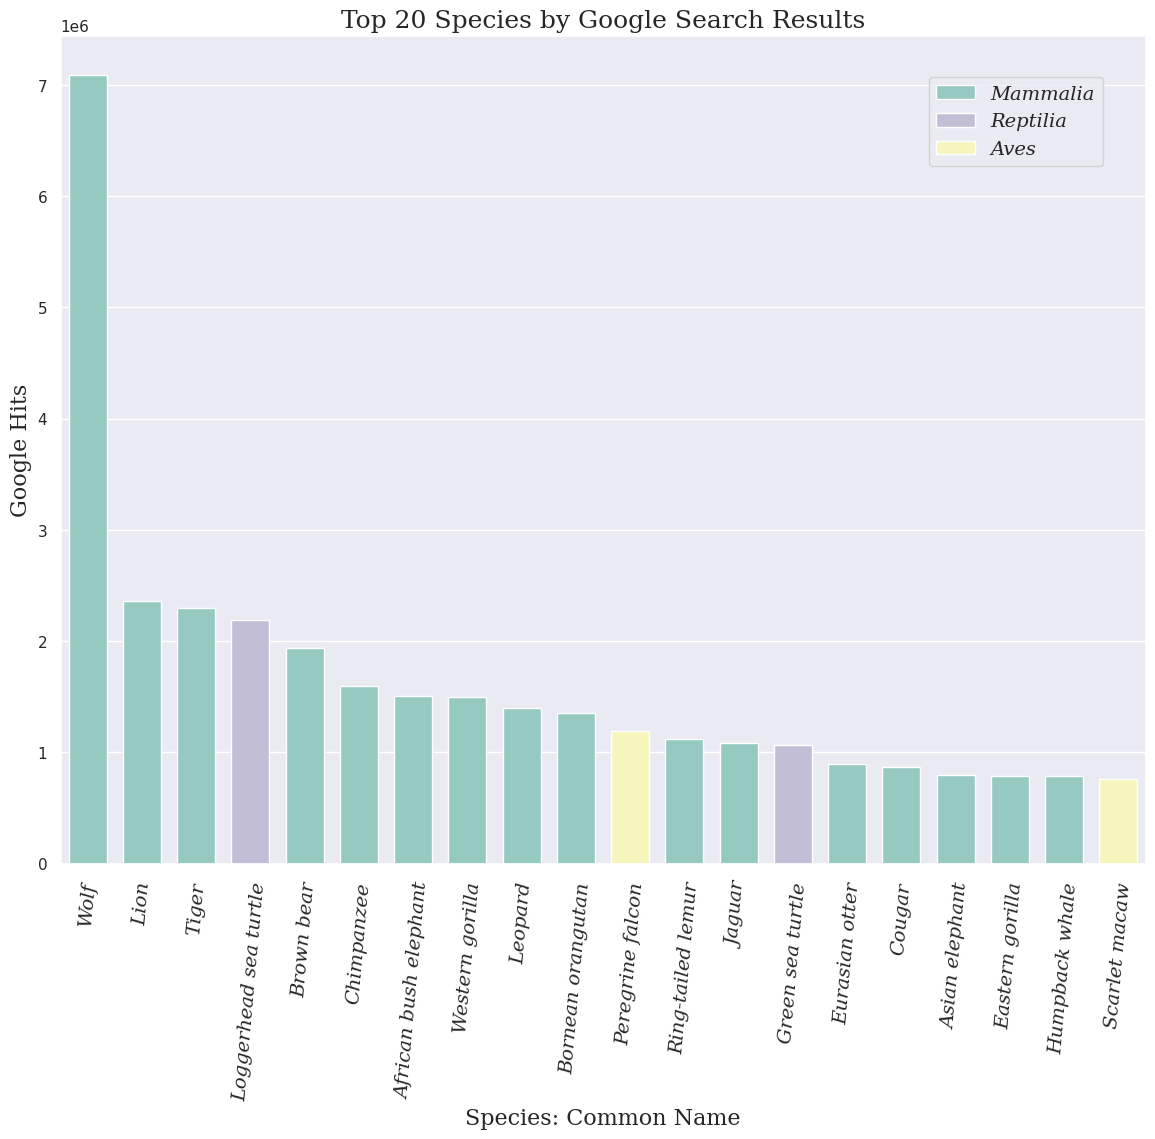

In [29]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

palette = {"Mammalia": "#8dd3c7", "Aves": "#ffffb3", "Reptilia": "#bebada"}

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,12)})
ax = sns.barplot(
    x = 'title',
    y = 'hits_renew',
    hue = 'Class',
    data = top20google, 
    width = 0.7, 
    palette = palette, 
    dodge = False
)

ax.set_xlabel('Species: Common Name', fontsize=16, family = "Serif")
ax.set_ylabel('Google Hits', fontsize=16, family = "Serif")
#ax.set_yscale('log')


# Add suptitle 
plt.title("Top 20 Species by Google Search Results", fontsize=18, family = 'Serif')
plt.subplots_adjust(top=0.80)


font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=14)
    
for label in ax.get_xticklabels():
    label.set_fontproperties(font)


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 14, left = True)
ax.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0, prop=font)
#plt.savefig('figures/top_20_species_google.png', bbox_inches = 'tight')